In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from torchvision import transforms
import overcomplete
from overcomplete.visualization import show


In [14]:
!wget -O rabbit.npz -q "https://github.com/KempnerInstitute/Overcomplete/blob/main/docs/assets/rabbit.npz?raw=True"

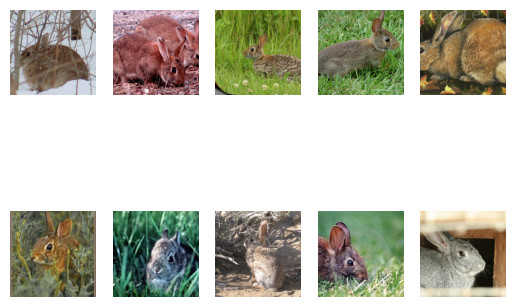

In [15]:
# show is able to plot any numpy/pil/tensor and handle various
# data format (channel first, last, no channel...)

images = np.load('rabbit.npz')['arr_0'].astype(np.uint8)
for i in range(10):
  plt.subplot(2, 5, i+1)
  show(images[i])
plt.show()

In [8]:
# lets load a model, and get the activations for this model !
# here we are going to use DinoV2, just because i love this model :)
from overcomplete.models import DinoV2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DinoV2(device=device)
to_pil = transforms.ToPILImage()

images = [
    model.preprocess(to_pil(image))
    for image in images
]

images = torch.stack(images).to(device)
images.shape

Using cache found in /Users/joaomata/.cache/torch/hub/facebookresearch_dinov2_main


torch.Size([300, 3, 224, 224])

In [10]:
# ok then forward and flatten to get the tokens
Activations = model.forward_features(images)

Activations = rearrange(Activations, 'n t d -> (n t) d')
Activations.shape

torch.Size([76800, 384])

In [11]:
# now the funny part, lets train a small topk sae
# we need a dataloader, a criterion and an optimizer
from torch.utils.data import DataLoader, TensorDataset
from overcomplete.sae import TopKSAE, train_sae

sae = TopKSAE(Activations.shape[-1], nb_concepts=10, top_k=2, device=device)

dataloader = torch.utils.data.DataLoader(TensorDataset(Activations), batch_size=1024, shuffle=True)
optimizer = torch.optim.Adam(sae.parameters(), lr=5e-4)

def criterion(x, x_hat, pre_codes, codes, dictionary):
  mse = (x - x_hat).square().mean()
  return mse

logs = train_sae(sae, dataloader, criterion, optimizer, nb_epochs=20, device=device)

Epoch[1/20], Loss: 4.6419, R2: 0.1003, L0: 1.9916, Dead Features: 0.0%, Time: 0.4898 seconds
Epoch[2/20], Loss: 3.1947, R2: 0.3808, L0: 2.0000, Dead Features: 30.0%, Time: 0.3241 seconds
Epoch[3/20], Loss: 2.7159, R2: 0.4736, L0: 2.0000, Dead Features: 20.0%, Time: 0.3310 seconds
Epoch[4/20], Loss: 2.6257, R2: 0.4911, L0: 2.0000, Dead Features: 20.0%, Time: 0.3284 seconds
Epoch[5/20], Loss: 2.5861, R2: 0.4988, L0: 2.0000, Dead Features: 10.0%, Time: 0.3795 seconds
Epoch[6/20], Loss: 2.5473, R2: 0.5063, L0: 1.9999, Dead Features: 0.0%, Time: 0.2762 seconds
Epoch[7/20], Loss: 2.5086, R2: 0.5138, L0: 1.9999, Dead Features: 10.0%, Time: 0.2978 seconds
Epoch[8/20], Loss: 2.4690, R2: 0.5215, L0: 1.9999, Dead Features: 10.0%, Time: 0.2636 seconds
Epoch[9/20], Loss: 2.4280, R2: 0.5294, L0: 1.9996, Dead Features: 0.0%, Time: 0.2487 seconds
Epoch[10/20], Loss: 2.3966, R2: 0.5355, L0: 1.9995, Dead Features: 0.0%, Time: 0.2721 seconds
Epoch[11/20], Loss: 2.3846, R2: 0.5378, L0: 1.9996, Dead Featur

Concept 0


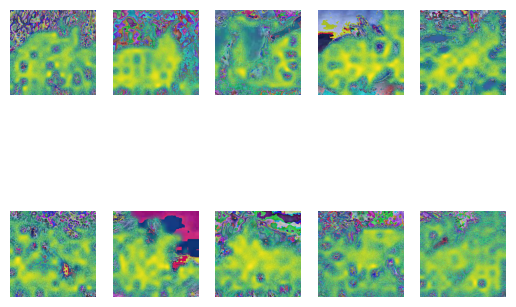

Concept 1


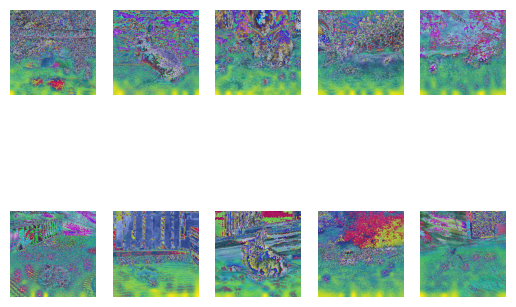

Concept 2


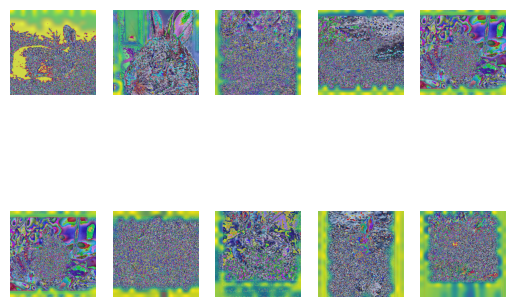

Concept 3


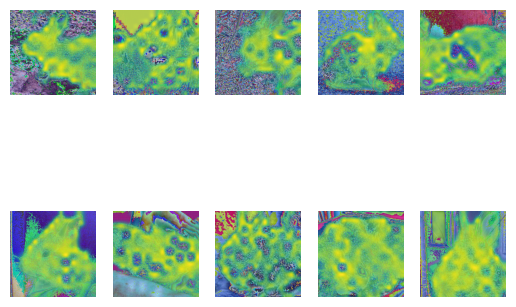

Concept 4


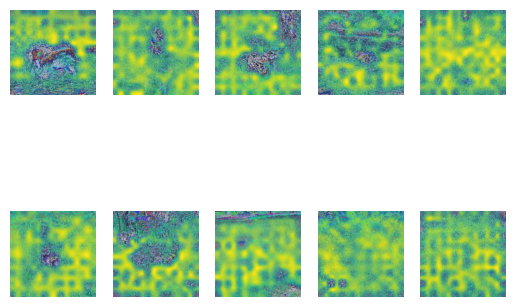

Concept 5


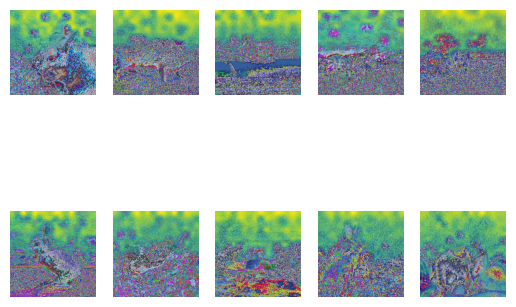

Concept 6


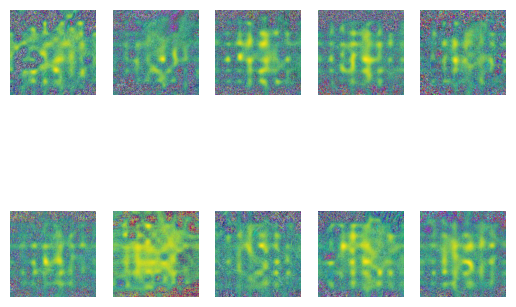

Concept 7


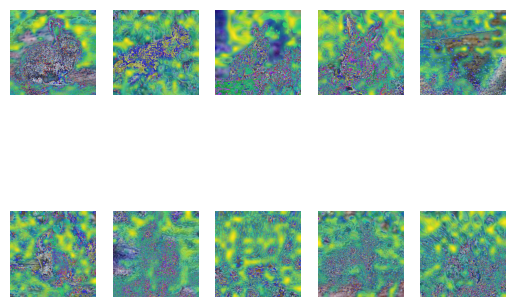

Concept 8


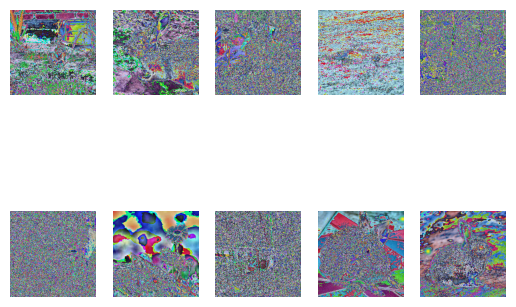

Concept 9


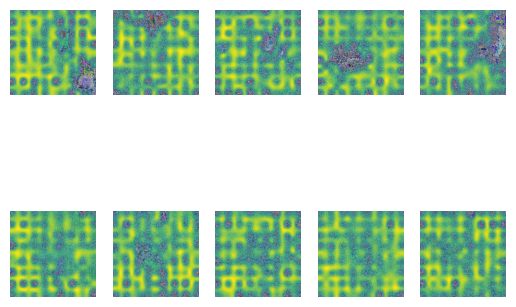

In [12]:
from overcomplete.visualization import overlay_top_heatmaps
# great, now let inspect the results !
# first we reshape the code to see them patch-wise
# then we will use `overlay_top_heatmaps`
# a little function to show the top concepts

sae = sae.eval()

with torch.no_grad():
  pre_codes, codes = sae.encode(Activations)

codes = rearrange(codes, '(n w h) d -> n w h d', w=16, h=16)

for i in range(10):
  print('Concept', i)
  overlay_top_heatmaps(images, codes, concept_id=i)
  plt.show()